In [8]:
import numpy as np
import nltk
# import ssl

nltk.download('gutenberg')
# nltk.download('all')

[nltk_data] Downloading package gutenberg to /home/ayush/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [9]:
class cbow:
	"""
	This class is an implementation of the continous bag of words model 
	by first principles. 

	CBOW model tries to predict the center words from the 
	surrounding words. 
	"""
	
	def __init__(self, text, window=2, n=2, learning_rate=0.0001):
		"""
		Initialize a new model for the current dataset. 
		"""
		self.n = n									# desired size of the word vectors
		self.text = text								# text passed for training the model 
		self.window = window								# window size given to learn the word vectors 
		self.learning_rate = learning_rate						# Defining the learning rate 
		self.vocabulary = list(set(text.lower().split()))        			# vocabulary of all the words in the dataset 
		self.word_index = {k: v for v, k in enumerate(self.vocabulary)}                 # generate index for each word in the vocabulary 
		self.V = np.random.uniform(-0.001, 0.001,  (n, len(self.vocabulary))) 		# input vector matrix for each word ( n X |V| )
		self.U = np.random.uniform(-0.001, 0.001 , (len(self.vocabulary), n)) 	        # output vector matrix for each word ( |V| X n )
		print ("Word vec size = %s " % self.n)
		print ("Vocabulary size = %s " % self.vocabulary)
		print ("Word Index dict = %s " % self.word_index)
		print ("Shape of V = %s " + str(self.V.shape))
		print ("Shape of U = %s " + str(self.U.shape))
		print ("V matrix = %s " + str(self.V))
		print ("U matrix = %s " + str(self.U))

	def get_one_hot(self, index):
		"""
		Given a word index, this function returns a one hot encoding. 
		"""
		one_hot = np.zeros(len(self.vocabulary))
		one_hot[index] = 1
		return one_hot 

	def get_representation_from_onehot(self, one_hot=None):
		""""
		This function returns a vector representation 
		using the onehot encoding. 
		"""
		temp = np.dot(self.V, one_hot)
		return temp

	def get_average_vector_context(self, left_context=None, right_context=None):
		"""
		Given the words in the left and right context, this 
		function generated the average vector for the 
		context of the current word 
		"""
		avg_vector = np.zeros(self.n)

		for word in left_context:							# Processing words in the left context 
			current_word_index = self.word_index[word]				# Get the index of the neighbouring word
			one_hot_encoding = self.get_one_hot(current_word_index) 		# get the one hot encoding of the current word 
			avg_vector += self.get_representation_from_onehot(one_hot=one_hot_encoding)

		for word in right_context:							# Continue the same for the words in the right context 
			current_word_index = self.word_index[word]
			one_hot_encoding = self.get_one_hot(current_word_index)
			avg_vector += self.get_representation_from_onehot(one_hot=one_hot_encoding)

		avg_vector = avg_vector/( 2 * self.window )
		return avg_vector

	def get_score(self, avg_vec=None):
		"""
		Given an averaged vector in the current context of the 
		center word, compute the product of the U with avg_vec.
		"""
		print ("U shape = " + str(self.U.shape))
		print ("Average vector shape = " + str(avg_vec.shape))
		return np.dot(self.U, avg_vec)

	def softmax(self, x):
		"""
		Return the softmax output of the given function.
		"""
		if x.ndim > 1:
			x -= np.max(x, axis=1).reshape(-1, 1)
			x = np.exp(x)/np.sum(np.exp(x), axis=1).reshape(-1, 1)
		else:
			x -= np.max(x)
			x = np.exp(x)/np.sum(np.exp(x))
		return x

	def compute_cross_entropy_error(self, y, y_hat):
		"""
		Given One hot encoding and the output of 
		the softmax function, this function 
		computes the cross entropy error. 

		Parameters 
		---------
		y : one_hot encoding of the current center word 
		y_hat : output of the softmax function. 
		"""
		return -y * np.log(y_hat)

	def compute_EH(self, error):
		"""
		Given error and the U matrix 
		compute the value of EH 
		"""		
		EH = np.zeros(self.n)
		for i in range(self.n):
			temp = 0.0
			for j in range(len(self.vocabulary)):
				temp += error[j] * self.U[j, i]
			EH[i] = temp 
		return EH

	def update_U(self, error, avg_vec):
		"""
		Given the cross entropy error occured in the current 
		sample, this function updates the U matrix. 
		"""
		for i in range(self.U.shape[0]):
			self.U[i, :] -= self.learning_rate * error[i] * avg_vec
		
	def update_V(self, error, left_context, right_context):
		"""
		This function updates the V matrix 
		"""
		# Compute EH term 
		EH = self.compute_EH(error)
		
		# pass the update 
		for word in left_context + right_context:
			current_word_index = self.word_index[word]
			self.V[:, current_word_index] -= ( 2 * self.window ) * self.learning_rate * EH

	def fit(self):
		"""
		Learn the values of V and U vectors with a window size of 2. 

		Parameters 
		----------
		text : piece of text 
		window : (int) window size to use 
		"""
		self.split_text = self.text.lower().split()
		for i in range(len(self.split_text)):
			print ("\n\n")
			center_word = self.split_text[i]								# centre word in the current context  
			if i - self.window < 0:
				left_window, right_window = self.split_text[:i], self.split_text[i+1:i+self.window]   	# left context and right context 
			else:
				left_window, right_window = self.split_text[i-self.window:i], self.split_text[i+1:i+self.window]	

			print ("Center word = %s, left_window = %s & right_window=%s" % (center_word, left_window, right_window))

			# Compute the avg vector using the left and right context 	
			avg_vector = self.get_average_vector_context(left_context=left_window, \
								     right_context=right_window)							
			
			# Get score 
			x_hat = self.get_score(avg_vector)
			print ("x_hat shape = " + str(x_hat.shape))

			# Get softmax 
			y_hat = self.softmax(x_hat)

			# Get the 1 - hot representation of the center word
			center_word_index = self.word_index[center_word]
			center_word_one_hot_encoding = self.get_one_hot(center_word_index)

			# Compute the error in prediction for the current center word 
			error = self.compute_cross_entropy_error(center_word_one_hot_encoding, y_hat)
			print ("Error = %s" % error)

			# Update U matrix 
			self.update_U(error=error, avg_vec=avg_vector)

			# Update V marix 
			self.update_V(error=error, left_context=left_window, right_context=right_window)

		# Final U matrix 
		print ("U matrix = %s " + str(self.U))

		# Final V matrix
		print ("V matrix = %s " + str(self.V))


Word vec size = 2 
Vocabulary size = ['chapter', 'period', '.', 'distress', ';', 'been', 'his', 'jane', 'world', 'house', 'in', 'handsome', 'comfortable', 'one', '1816', 'father', 'was', 'home', "'", 'early', 'best', 'clever', 'by', 'blessings', 'twenty', 'a', 'nearly', 'volume', ',', 'happy', 'unite', 'or', 'youngest', 'i', 'mistress', 'rich', 'disposition', 'most', 'from', 's', '[', 'existence', 'she', 'some', 'with', 'woodhouse', 'little', 'to', 'vex', 'consequence', 'years', 'emma', 'the', 'affectionate', ']', 'austen', 'had', 'very', 'two', 'sister', 'and', '-', 'daughters', 'of', 'seemed', 'lived', 'marriage', 'her', 'indulgent'] 
Word Index dict = {'chapter': 0, 'period': 1, '.': 2, 'distress': 3, ';': 4, 'been': 5, 'his': 6, 'jane': 7, 'world': 8, 'house': 9, 'in': 10, 'handsome': 11, 'comfortable': 12, 'one': 13, '1816': 14, 'father': 15, 'was': 16, 'home': 17, "'": 18, 'early': 19, 'best': 20, 'clever': 21, 'by': 22, 'blessings': 23, 'twenty': 24, 'a': 25, 'nearly': 26, 'volu

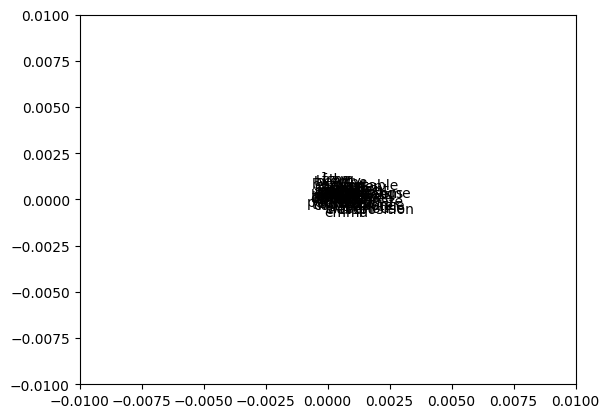

In [12]:
text = nltk.corpus.gutenberg.words('austen-emma.txt')
text = ' '.join(text[:100])

model  = cbow(text=text)
model.fit()

final_vectors = {}
for k, v in model.word_index.items():
	print(k,v)
	final_vectors[k] = (model.U[v, :] + model.V[:, v])/2

# print (final_vectors)

import matplotlib.pylab as plt
for k, v in final_vectors.items():
	plt.text(v[0], v[1], k)

plt.xlim(-0.01, 0.01)
plt.ylim(-0.01, 0.01)
plt.show()